res = (420, 236), n_data = 99120
data.shape = torch.Size([99120, 1])
uv.shape = torch.Size([99120, 1])


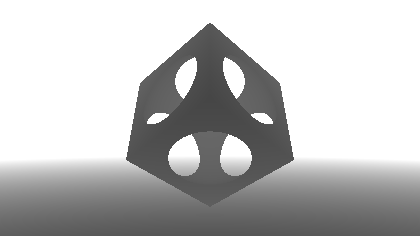

In [67]:
import torch
import torch.nn as nn
import torch.functional as F
from torchvision import transforms
import torchvision
from PIL import Image
import numpy as np

data_img = Image.open("./test_small2.png")
res = data_img.size
print(f"res = {res}, n_data = {res[0] * res[1]}")

# data = torch.reshape(
#     torch.transpose(
#         transforms.ToTensor()(data_img)[0], 0, 1),
#         (res[0] * res[1], 1))
data = torch.reshape(
        transforms.ToTensor()(data_img)[0],
        (res[0] * res[1], 1))
print(f"data.shape = {data.shape}")

# uv = np.mgrid[0:res[0]:1, 0:res[1]:1].reshape(2,-1).T
# uv = torch.Tensor(uv).to(torch.long)
# print(uv.shape)

uv = torch.reshape(
    torch.Tensor(np.array(range(0, res[0]*res[1]))),
    (res[0] * res[1], 1))

print(f"uv.shape = {uv.shape}")

data_img

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class sdf_net(nn.Module):
    def __init__(self):
        super(sdf_net, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 5),
            nn.Sigmoid(),
            nn.Linear(5, 5),
            nn.Sigmoid(),
            nn.Linear(5, 1),
            nn.Softmax()
        )
    
    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x 

model = sdf_net().to(device)
loss_fn = nn.MSELoss(reduction='mean')
# loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

def train(model, loss_fn, optimizer):

    pred = model(uv)
    loss = loss_fn(pred, data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

max_iter = 200
loss_list = []

for t in range(max_iter):
    loss = train(model, loss_fn, optimizer)
    loss_list.append(loss)
    if t % 100 == 0:
        print(f"{t}: {loss}")

Using cpu device
0: 0.1459236443042755


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


100: 0.1459236443042755


In [66]:
fit = model(uv).cpu().detach()
print(fit)

(fit - data).norm()

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor(120.2656)

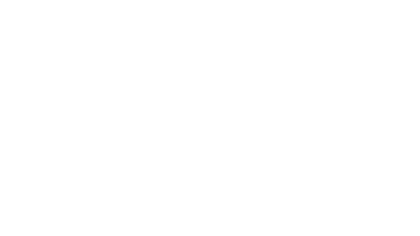

In [65]:
fit = torch.reshape(
    fit,
    (res[1], res[0])
)

fit_to_pil_img = transforms.ToPILImage()(fit)
fit_to_pil_img